In [8]:
cd C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis\

C:\Users\Majd Mustapha\DSP\AirlineSentimentAnalysis


In [9]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import display
from sys import getsizeof
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# storing data directories for this notebook.
img_out_dir = 'data/images/EDA_NB2/'
data_out_dir = 'data/pickled/EDA_NB2/'

# used to prin t word cloud in twitter bird shape.
from PIL import Image
wc_image_mask = np.array(Image.open('data/twitter.png'))

%matplotlib inline

## Airline Sentiment Classification

Dataset Description from Kaggle:<br>
Classifies customer sentiment towards major U.S. airlines, based on twitter data. Tweets were scraped from February of 2015 and contributors were asked to classify tweets by positive, negative, and neutral categories, followed by categorizing negative reasons (such as “late flight” or “rude service”).

The Kaggle Dataset contains tweets and categories for 14,640k airline related tweets, classified into one of 3 sentiment categories (positive, negative, neutral). 
<br>Let's see if I can accurately classify the tweet sentiment category based on the text.


### EDA on last 6640 rows of dataset. Had to split rows since calculating the sum of the columns<br>used to kill the kernel. 

In [14]:
air_full_df = pd.read_csv('data/csvfiles/kaggle_airline_dataset.csv', encoding='utf-8')

In [15]:
air_full_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [16]:
# look at last 6640 rows.
air_full_df = air_full_df.iloc[8000:, :]

In [17]:
# data size of full kaggle dataset.
air_full_df.shape

(6640, 15)

In [18]:
air_full_df.columns

Index([u'tweet_id', u'airline_sentiment', u'airline_sentiment_confidence',
       u'negativereason', u'negativereason_confidence', u'airline',
       u'airline_sentiment_gold', u'name', u'negativereason_gold',
       u'retweet_count', u'text', u'tweet_coord', u'tweet_created',
       u'tweet_location', u'user_timezone'],
      dtype='object')

In [19]:
air_full_df.airline_sentiment.value_counts()

negative    4618
neutral     1145
positive     877
Name: airline_sentiment, dtype: int64

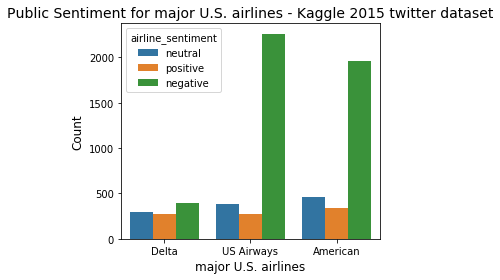

In [20]:
# Airline sentiment.
sns.countplot(x="airline", hue="airline_sentiment", data=air_full_df)
plt.title('Public Sentiment for major U.S. airlines - Kaggle 2015 twitter dataset',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_airline_sentiment_hist.png')

In [21]:
# What are reasons for customer dissatisfaction?
# Explore this to make recommendations at the end from findings.

In [22]:
# plot negative reason value_counts.
neg_reason = air_full_df.negativereason[air_full_df.negativereason.notnull()]
neg_reason.value_counts()

Customer Service Issue         1677
Late Flight                     801
Can't Tell                      510
Cancelled Flight                463
Lost Luggage                    328
Flight Booking Problems         271
Flight Attendant Complaints     231
Bad Flight                      218
longlines                        86
Damaged Luggage                  33
Name: negativereason, dtype: int64

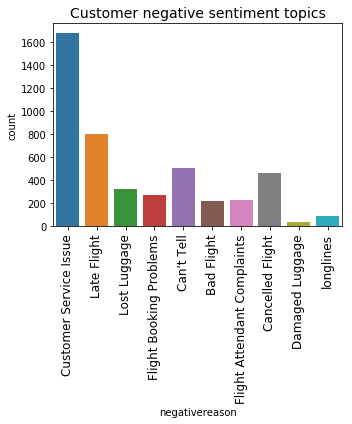

In [23]:
plt.figure(figsize=(5,6))
sns.countplot(x="negativereason", data=air_full_df)
plt.grid(0)
plt.xticks(rotation = 90, fontsize=12)
plt.title("Customer negative sentiment topics", fontsize=14)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_customer_neg_sent_topics_hist.png')

In [24]:
# airlines 
air_full_df.airline.unique()

array([u'Delta', u'US Airways', u'American'], dtype=object)

In [25]:
# data types
air_full_df.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [26]:
# check for null values.
air_full_df.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  2022
negativereason_confidence       1490
airline                            0
airline_sentiment_gold          6617
name                               0
negativereason_gold             6621
retweet_count                      0
text                               0
tweet_coord                     6233
tweet_created                      0
tweet_location                  2255
user_timezone                   2284
dtype: int64

In [27]:
# get subset with cols = ['airline', 'text', 'airline_sentiment', 'airline_sentiment:confidence']

In [28]:
sub_cols = ['text', 'airline_sentiment', 'airline_sentiment_confidence', 
            'negativereason', 'airline']
air_sub_df = air_full_df.loc[:, sub_cols]

In [29]:
del air_full_df

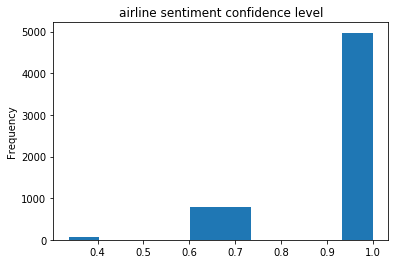

In [30]:
# look at the confidence of values for the 3 categories.
air_sub_df.airline_sentiment_confidence.plot(kind='hist', title='airline sentiment confidence level')
plt.grid(0)

In [31]:
(air_sub_df.airline_sentiment_confidence >= 0.7).sum(), air_sub_df.shape

(5112, (6640, 5))

In [32]:
# let's only keep tweets where the airline_sentiment_confidence is > 0.7

In [33]:
mask = air_sub_df.airline_sentiment_confidence >= 0.7

air_sub_df = air_sub_df.loc[mask,:]

In [34]:
# dataframe with airline sentiment data with 
air_sub_df.shape

(5112, 5)

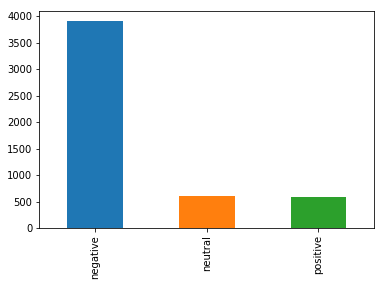

In [35]:
# look at the count of values for the 3 categories.
air_sub_df.airline_sentiment.value_counts().plot(kind='bar')
plt.grid(0)

In [36]:
air_sub_df.head()

text airline_sentiment  \
8000  @JetBlue do you have any afternoon flights goi...           neutral   
8001  @JetBlue I'm flying your airline just out of #...           neutral   
8002  @JetBlue he loved the #natural #beefjerky snac...          positive   
8004  @JetBlue who is he I must send a note!!! Too g...          positive   
8006        @JetBlue can't seem to DM you guys.. JDHADP          negative   

      airline_sentiment_confidence          negativereason airline  
8000                        1.0000                     NaN   Delta  
8001                        1.0000                     NaN   Delta  
8002                        0.7153                     NaN   Delta  
8004                        1.0000                     NaN   Delta  
8006                        1.0000  Customer Service Issue   Delta

In [37]:
air_sub_df[air_sub_df.airline_sentiment == 'positive']['text'][:10]

8002    @JetBlue he loved the #natural #beefjerky snac...
8004    @JetBlue who is he I must send a note!!! Too g...
8007    @JetBlue - loving Capt Joe on our flight from ...
8010              @JetBlue It was fabulous! Very pleased.
8015    @JetBlue No worries. Time flew in the terminal...
8018                          @JetBlue I will. Thank you!
8028    @JetBlue Thanks for the reminder of a few olde...
8036    @JetBlue heading to Buffalo... trading the col...
8038    @JetBlue Of course U know I would like 2 lay y...
8042    @JetBlue OOH! Good one! Speaking of #MiAmore -...
Name: text, dtype: object

In [38]:
air_sub_df[air_sub_df.airline_sentiment == 'negative']['text'][:10]

8006          @JetBlue can't seem to DM you guys.. JDHADP
8008    @JetBlue Two delays.  A little proactive commu...
8020    @JetBlue poor storm customer service, 1hr take...
8022    @JetBlue before departure, while people who ar...
8025    @JetBlue has the worst customer service out of...
8026    @JetBlue what's up with the random delay on fl...
8027    @JetBlue I lost a day at the airport and off m...
8031            @JetBlue what is the reason for the delay
8058    @JetBlue dont really know what that means but ...
8062    @JetBlue I ❤️ Jetblue but i was on flt 277 fro...
Name: text, dtype: object

In [39]:
air_sub_df[air_sub_df.airline_sentiment == 'neutral']['text'][:10]

8000    @JetBlue do you have any afternoon flights goi...
8001    @JetBlue I'm flying your airline just out of #...
8011    @JetBlue I'll take 3 round trip tickets to the...
8029    @JetBlue can I switch my seat for my trip on S...
8034                        @JetBlue is flt 1202 delayed?
8039    @JetBlue Now ur asking for the heavy guns! You...
8040    @JetBlue well mine sure aren't anything to wri...
8043    @JetBlue well I'm not sure I'm that bold! lol ...
8046    @JetBlue and The from @WSJ Team to Offer In-#F...
8061         @JetBlue why don't you fly to #nashville? :(
Name: text, dtype: object

In [40]:
# target.
y = air_sub_df['airline_sentiment']

In [41]:
# unique values of y.
y.unique()

array([u'neutral', u'positive', u'negative'], dtype=object)

In [42]:
#*********** Let's try to look at the top words in each of the categories, using CountVectorizer() *************

In [43]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [44]:
from nltk.stem.porter import PorterStemmer
import emoji
import string

In [45]:
# exclude name of airlines from the tweets. 
exclude = ['virginamerica', 'united', 'southwestair', 'delta', 'usairways',
           'americanair', 'jetblue', 'southwest', 'flight', 'flights',
           'URL', 'AT_USER', 'amp', 'amp;']

In [46]:
# define stop words. Use the defined 'english' stop words. I will add the airline names to that.
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.extend(exclude)
exclude_punctuation = set(string.punctuation) 

In [47]:
def tokenize(text):
    return(text.split())

In [48]:
def cleaner(text):
    
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username to AT_USER
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean
    text = re.sub('&#39;','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [49]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    token_text = tokenize(text)
    text = ' '.join(i for i in token_text if (i not in stop_words))
    return(text)

In [50]:
def stemming(text):
    '''
    eliminate plurals and redundancy of words (ie thank, thanks)
    '''
    ps = PorterStemmer()
    text = tokenize(text)
    text = ' '.join(ps.stem(word) for word in text)
    return(text)

## Clean Text
```(eliminate web tags, punctuation, symbols...)```

In [51]:
air_sub_df.columns

Index([u'text', u'airline_sentiment', u'airline_sentiment_confidence',
       u'negativereason', u'airline'],
      dtype='object')

In [52]:
# create a new category 'clean_text' with clean text.
air_sub_df['clean_text'] = air_sub_df['text'].apply(cleaner)

In [53]:
# Let's see what the clean data looks like.

In [54]:
air_sub_df[['clean_text', 'text']][y=='positive'][:10]

clean_text  \
8002            he loved the natural beefjerky snacks😉   
8004    who is he i must send a note too good for words   
8007  loving capt joe on our flight from bos to sfo ...   
8010                       it was fabulous very pleased   
8015  no worries time flew in the terminal and now w...   
8018                                   i will thank you   
8028  thanks for the reminder of a few older flights...   
8036  heading to buffalo trading the cold in boston ...   
8038  of course u know i would like 2 lay you down i...   
8042  ooh good one speaking of miamore  just know th...   

                                                   text  
8002  @JetBlue he loved the #natural #beefjerky snac...  
8004  @JetBlue who is he I must send a note!!! Too g...  
8007  @JetBlue - loving Capt Joe on our flight from ...  
8010            @JetBlue It was fabulous! Very pleased.  
8015  @JetBlue No worries. Time flew in the terminal...  
8018                        @JetBlue I will. Thank you!  
8028  @JetBlue Thanks for the reminder of a few olde...  
8036  @JetBlue heading to Buffalo... trading the col...  
8038  @JetBlue Of course U know I would like 2 lay y...  
8042  @JetBlue OOH! Good one! Speaking of #MiAmore -...

In [55]:
air_sub_df.loc[8002, 'text']

u'@JetBlue he loved the #natural #beefjerky snacks\U0001f609'

In [56]:
air_sub_df.loc[8002, 'clean_text']

u'he loved the natural beefjerky snacks\U0001f609'

In [57]:
air_sub_df[['clean_text', 'text']][y=='negative'][:10]

clean_text  \
8006                    cant seem to dm you guys jdhadp   
8008  two delays a little proactive communication go...   
8020  poor storm customer service 1hr takeoff delay ...   
8022  before departure while people who are delayed ...   
8025  has the worst customer service out of any airl...   
8026  whats up with the random delay on flight 1729 ...   
8027  i lost a day at the airport and off my trip i ...   
8031                   what is the reason for the delay   
8058  dont really know what that means but this isnt...   
8062  i ❤️ jetblue but i was on flt 277 from fll to ...   

                                                   text  
8006        @JetBlue can't seem to DM you guys.. JDHADP  
8008  @JetBlue Two delays.  A little proactive commu...  
8020  @JetBlue poor storm customer service, 1hr take...  
8022  @JetBlue before departure, while people who ar...  
8025  @JetBlue has the worst customer service out of...  
8026  @JetBlue what's up with the random delay on fl...  
8027  @JetBlue I lost a day at the airport and off m...  
8031          @JetBlue what is the reason for the delay  
8058  @JetBlue dont really know what that means but ...  
8062  @JetBlue I ❤️ Jetblue but i was on flt 277 fro...

In [58]:
air_sub_df.loc[8062, 'text']

u'@JetBlue I \u2764\ufe0f Jetblue but i was on flt 277 from fll to sfo. tke off was over 1 hr Late Flight, div to phx &amp; got in 2 hrs Late Flight. What will be done?'

In [59]:
air_sub_df.loc[8062, 'clean_text']

u'i \u2764\ufe0f jetblue but i was on flt 277 from fll to sfo tke off was over 1 hr late flight div to phx amp got in 2 hrs late flight what will be done'

In [60]:
air_sub_df[['clean_text', 'text']][y=='neutral'][:10]

clean_text  \
8000  do you have any afternoon flights going from b...   
8001          im flying your airline just out of lga 😷   
8011  ill take 3 round trip tickets to the closest w...   
8029         can i switch my seat for my trip on sunday   
8034                                is flt 1202 delayed   
8039  now ur asking for the heavy guns you know iwou...   
8040  well mine sure arent anything to write home about   
8043  well im not sure im that bold lol or are you s...   
8046  and the from team to offer inflight access to ...   
8061                      why dont you fly to nashville   

                                                   text  
8000  @JetBlue do you have any afternoon flights goi...  
8001  @JetBlue I'm flying your airline just out of #...  
8011  @JetBlue I'll take 3 round trip tickets to the...  
8029  @JetBlue can I switch my seat for my trip on S...  
8034                      @JetBlue is flt 1202 delayed?  
8039  @JetBlue Now ur asking for the heavy guns! You...  
8040  @JetBlue well mine sure aren't anything to wri...  
8043  @JetBlue well I'm not sure I'm that bold! lol ...  
8046  @JetBlue and The from @WSJ Team to Offer In-#F...  
8061       @JetBlue why don't you fly to #nashville? :(

In [61]:
air_sub_df.loc[8001, 'text']

u"@JetBlue I'm flying your airline just out of #LGA \U0001f637"

In [62]:
air_sub_df.loc[8001, 'clean_text']

u'im flying your airline just out of lga \U0001f637'

## Reduce dimensionality - using english stop words
```(eliminating english stop words that typically don't impart much meaning like prepositions, pronouns... I will also remove twitter handle and urls encoded above, in the cleaner method, as AT_USER and URL.```

In [63]:
# create a new category 'stopw_clean_text' to store reduced dimensionality text,
# by eliminating english stop words.
air_sub_df['stopw_clean_text'] = air_sub_df['clean_text'].apply(remove_stopwords)

In [64]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='positive'][:10]

stopw_clean_text  \
8002                   loved natural beefjerky snacks😉   
8004                               send note good words   
8007                    loving capt joe bos sfo 633 fun   
8010                                   fabulous pleased   
8015           worries time flew terminal taking thanks   
8018                                              thank   
8028  thanks reminder older id taken easy access add...   
8036  heading buffalo trading cold boston colder buf...   
8038  course u know like 2 lay bedofroses long theyr...   
8042  ooh good speaking miamore just know iadore lov...   

                                             clean_text  
8002            he loved the natural beefjerky snacks😉  
8004    who is he i must send a note too good for words  
8007  loving capt joe on our flight from bos to sfo ...  
8010                       it was fabulous very pleased  
8015  no worries time flew in the terminal and now w...  
8018                                   i will thank you  
8028  thanks for the reminder of a few older flights...  
8036  heading to buffalo trading the cold in boston ...  
8038  of course u know i would like 2 lay you down i...  
8042  ooh good one speaking of miamore  just know th...

In [65]:
air_sub_df.loc[8002, 'clean_text']

u'he loved the natural beefjerky snacks\U0001f609'

In [66]:
air_sub_df.loc[8002, 'stopw_clean_text']

u'loved natural beefjerky snacks\U0001f609'

In [67]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='negative'][:10]

stopw_clean_text  \
8006                                     dm guys jdhadp   
8008  delays little proactive communication goes lon...   
8020  poor storm customer service 1hr takeoff delay ...   
8022       departure people delayed 200 compensate time   
8025  worst customer service airline company dontfly...   
8026         whats random delay 1729 chance false alarm   
8027    lost day airport trip compensated inconvenience   
8031                                       reason delay   
8058  dont really know means isnt best firsttimeflyi...   
8062  ❤️ flt 277 fll sfo tke 1 hr late div phx got 2...   

                                             clean_text  
8006                    cant seem to dm you guys jdhadp  
8008  two delays a little proactive communication go...  
8020  poor storm customer service 1hr takeoff delay ...  
8022  before departure while people who are delayed ...  
8025  has the worst customer service out of any airl...  
8026  whats up with the random delay on flight 1729 ...  
8027  i lost a day at the airport and off my trip i ...  
8031                   what is the reason for the delay  
8058  dont really know what that means but this isnt...  
8062  i ❤️ jetblue but i was on flt 277 from fll to ...

In [68]:
air_sub_df.loc[8062, 'clean_text']

u'i \u2764\ufe0f jetblue but i was on flt 277 from fll to sfo tke off was over 1 hr late flight div to phx amp got in 2 hrs late flight what will be done'

In [69]:
air_sub_df.loc[8062, 'stopw_clean_text']

u'\u2764\ufe0f flt 277 fll sfo tke 1 hr late div phx got 2 hrs late'

In [70]:
air_sub_df[['stopw_clean_text', 'clean_text']][y=='neutral'][:10]

stopw_clean_text  \
8000              afternoon going bqn jfk early morning   
8001                      im flying airline just lga 😷   
8011  ill 3 round trip tickets closest warmest place...   
8029                            switch seat trip sunday   
8034                                   flt 1202 delayed   
8039  ur asking heavy guns know iwoulddoanythingforl...   
8040                              sure arent write home   
8043         im sure im bold lol saying didnt believe p   
8046  team offer inflight access journal digital jou...   
8061                                 dont fly nashville   

                                             clean_text  
8000  do you have any afternoon flights going from b...  
8001          im flying your airline just out of lga 😷  
8011  ill take 3 round trip tickets to the closest w...  
8029         can i switch my seat for my trip on sunday  
8034                                is flt 1202 delayed  
8039  now ur asking for the heavy guns you know iwou...  
8040  well mine sure arent anything to write home about  
8043  well im not sure im that bold lol or are you s...  
8046  and the from team to offer inflight access to ...  
8061                      why dont you fly to nashville

In [71]:
air_sub_df.loc[8001, 'clean_text']

u'im flying your airline just out of lga \U0001f637'

In [72]:
air_sub_df.loc[8001, 'stopw_clean_text']

u'im flying airline just lga \U0001f637'

## Further reduce dimensionality - using stemming 
```(Stemming attempts to find the root of the word by chopping off the end, like thanks becoms thank...)```

In [73]:
# create a new category 'stem_stopw_clean_text' to store reduced dimensionality text,
# by finding root of words.
air_sub_df['stem_stopw_clean_text'] = air_sub_df['stopw_clean_text'].apply(stemming)

In [74]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='positive'][:10]

stem_stopw_clean_text  \
8002                      love natur beefjerki snacks😉   
8004                                send note good word   
8007                       love capt joe bo sfo 633 fun   
8010                                        fabul pleas   
8015                  worri time flew termin take thank   
8018                                              thank   
8028  thank remind older id taken easi access add po...   
8036  head buffalo trade cold boston colder buffalo ...   
8038  cours u know like 2 lay bedofros long theyr mi...   
8042  ooh good speak miamor just know iador love lov...   

                                       stopw_clean_text  
8002                   loved natural beefjerky snacks😉  
8004                               send note good words  
8007                    loving capt joe bos sfo 633 fun  
8010                                   fabulous pleased  
8015           worries time flew terminal taking thanks  
8018                                              thank  
8028  thanks reminder older id taken easy access add...  
8036  heading buffalo trading cold boston colder buf...  
8038  course u know like 2 lay bedofroses long theyr...  
8042  ooh good speaking miamore just know iadore lov...

In [75]:
air_sub_df.loc[8002, 'stopw_clean_text']

u'loved natural beefjerky snacks\U0001f609'

In [76]:
air_sub_df.loc[8002, 'stem_stopw_clean_text']

u'love natur beefjerki snacks\U0001f609'

In [77]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='negative'][:10]

stem_stopw_clean_text  \
8006                                      dm guy jdhadp   
8008  delay littl proactiv commun goe long way howha...   
8020  poor storm custom servic 1hr takeoff delay wai...   
8022              departur peopl delay 200 compens time   
8025     worst custom servic airlin compani dontflythem   
8026            what random delay 1729 chanc fals alarm   
8027            lost day airport trip compens inconveni   
8031                                       reason delay   
8058  dont realli know mean isnt best firsttimeflyin...   
8062  ❤️ flt 277 fll sfo tke 1 hr late div phx got 2...   

                                       stopw_clean_text  
8006                                     dm guys jdhadp  
8008  delays little proactive communication goes lon...  
8020  poor storm customer service 1hr takeoff delay ...  
8022       departure people delayed 200 compensate time  
8025  worst customer service airline company dontfly...  
8026         whats random delay 1729 chance false alarm  
8027    lost day airport trip compensated inconvenience  
8031                                       reason delay  
8058  dont really know means isnt best firsttimeflyi...  
8062  ❤️ flt 277 fll sfo tke 1 hr late div phx got 2...

In [78]:
air_sub_df.loc[8062, 'stopw_clean_text']

u'\u2764\ufe0f flt 277 fll sfo tke 1 hr late div phx got 2 hrs late'

In [79]:
air_sub_df.loc[8062, 'stem_stopw_clean_text']

u'\u2764\ufe0f flt 277 fll sfo tke 1 hr late div phx got 2 hr late'

In [80]:
air_sub_df[['stem_stopw_clean_text', 'stopw_clean_text']][y=='neutral'][:10]

stem_stopw_clean_text  \
8000                    afternoon go bqn jfk earli morn   
8001                          im fli airlin just lga 😷   
8011  ill 3 round trip ticket closest warmest place ...   
8029                            switch seat trip sunday   
8034                                     flt 1202 delay   
8039  ur ask heavi gun know iwoulddoanythingforlov b...   
8040                              sure arent write home   
8043             im sure im bold lol say didnt believ p   
8046   team offer inflight access journal digit journal   
8061                                   dont fli nashvil   

                                       stopw_clean_text  
8000              afternoon going bqn jfk early morning  
8001                      im flying airline just lga 😷  
8011  ill 3 round trip tickets closest warmest place...  
8029                            switch seat trip sunday  
8034                                   flt 1202 delayed  
8039  ur asking heavy guns know iwoulddoanythingforl...  
8040                              sure arent write home  
8043         im sure im bold lol saying didnt believe p  
8046  team offer inflight access journal digital jou...  
8061                                 dont fly nashville

In [81]:
air_sub_df.loc[8001, 'stopw_clean_text']

u'im flying airline just lga \U0001f637'

In [82]:
air_sub_df.loc[8001, 'stem_stopw_clean_text']

u'im fli airlin just lga \U0001f637'

In [83]:
# Let's make a word cloud to visualize the clean text data.

In [84]:
def make_wordcloud(data, title, filename, mask):
    plt.figure(figsize=(7,7))
    im = WordCloud(max_words=300, mask=mask).generate(' '.join(i for i in data))
    plt.grid(0)
    plt.title(title, fontsize=14)
    im.to_file(img_out_dir+filename)
    plt.imshow(im)

## Positive class

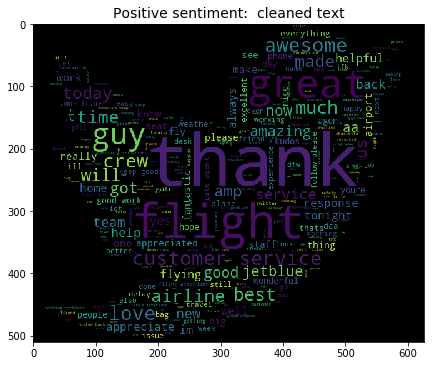

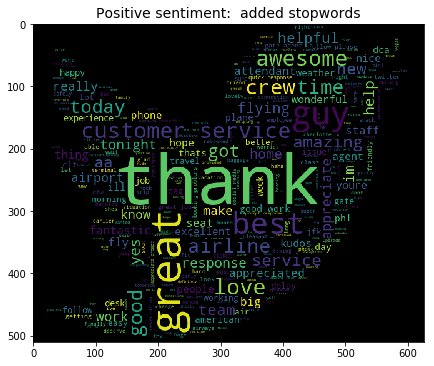

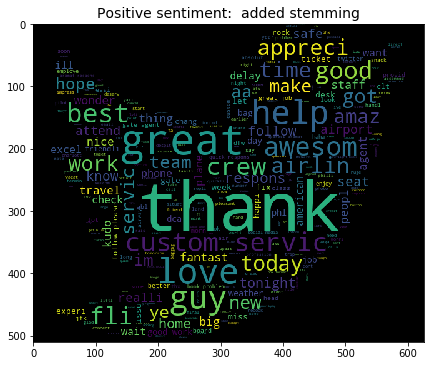

In [85]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='positive']
title = "Positive sentiment:  cleaned text"
filename = 'WordCld_pos_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stopwords"
filename = 'WordCld_pos_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='positive']
title = "Positive sentiment:  added stemming"
filename = 'WordCld_pos_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Negative class

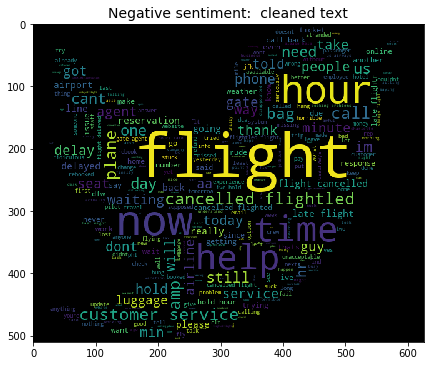

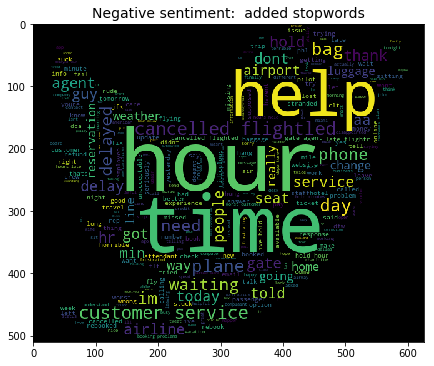

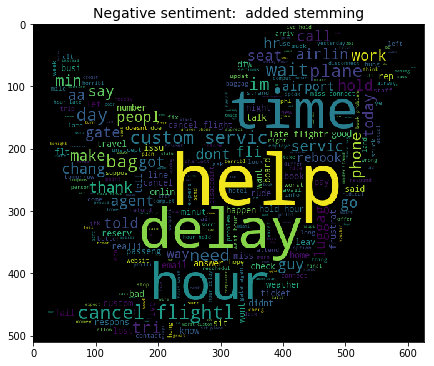

In [86]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='negative']
title = "Negative sentiment:  cleaned text"
filename = 'WordCld_neg_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stopwords"
filename = 'WordCld_neg_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='negative']
title = "Negative sentiment:  added stemming"
filename = 'WordCld_neg_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

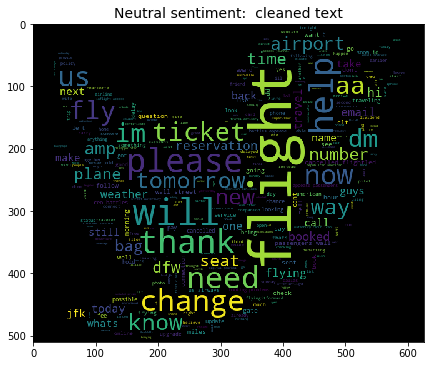

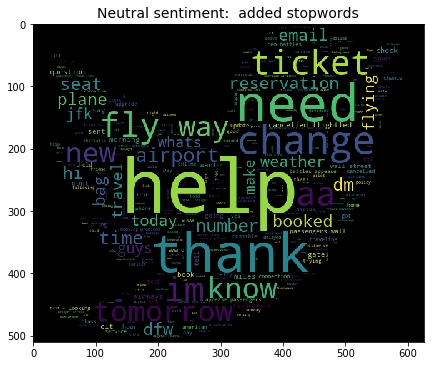

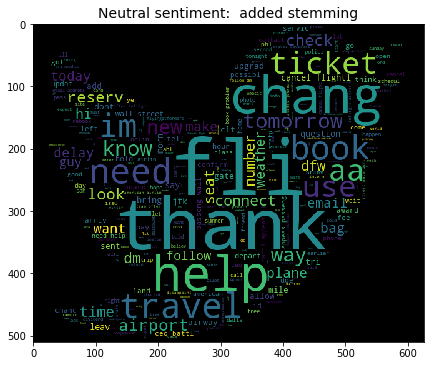

In [87]:
# only cleaned text.

# twitter logo.
mask = wc_image_mask

data = air_sub_df['clean_text'][y=='neutral']
title = "Neutral sentiment:  cleaned text"
filename = 'WordCld_neut_sent_cleantext.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = air_sub_df['stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stopwords"
filename = 'WordCld_neut_sent_stopwused.png'
make_wordcloud(data, title, filename, mask)

data = air_sub_df['stem_stopw_clean_text'][y=='neutral']
title = "Neutral sentiment:  added stemming"
filename = 'WordCld_neut_sent_stemused.png'
make_wordcloud(data, title, filename, mask)

## Feature extraction using CountVectorizer() 
```compare results of using 'clean text', 'added stopwords', and 'added stemming'.```

## Look at uni-grams 

In [88]:
grams = "Unigrams"

In [89]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(1,1))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(1,1))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(1,1))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y


In [90]:
print(words_df.shape)
words_df.head(4)

(5112, 7621)


006  0223  02282015  03  0303  03032015  0316  \
airline_sentiment                                                  
neutral              0     0         0   0     0         0     0   
neutral              0     0         0   0     0         0     0   
positive             0     0         0   0     0         0     0   
positive             0     0         0   0     0         0     0   

                   0372389047497  0400  0600    ...      yvonne  yvr  yyz  z1  \
airline_sentiment                               ...                             
neutral                        0     0     0    ...           0    0    0   0   
neutral                        0     0     0    ...           0    0    0   0   
positive                       0     0     0    ...           0    0    0   0   
positive                       0     0     0    ...           0    0    0   0   

                   zero  zfv  zip  zone  zoom  zurichnew  
airline_sentiment                                         
neutral               0    0    0     0     0          0  
neutral               0    0    0     0     0          0  
positive              0    0    0     0     0          0  
positive              0    0    0     0     0          0  

[4 rows x 7621 columns]

In [91]:
print(words_stop_df.shape)
words_stop_df.head(4)

(5112, 7371)


006  0223  02282015  03  0303  03032015  0316  \
airline_sentiment                                                  
neutral              0     0         0   0     0         0     0   
neutral              0     0         0   0     0         0     0   
positive             0     0         0   0     0         0     0   
positive             0     0         0   0     0         0     0   

                   0372389047497  0400  0600    ...      yvonne  yvr  yyz  z1  \
airline_sentiment                               ...                             
neutral                        0     0     0    ...           0    0    0   0   
neutral                        0     0     0    ...           0    0    0   0   
positive                       0     0     0    ...           0    0    0   0   
positive                       0     0     0    ...           0    0    0   0   

                   zero  zfv  zip  zone  zoom  zurichnew  
airline_sentiment                                         
neutral               0    0    0     0     0          0  
neutral               0    0    0     0     0          0  
positive              0    0    0     0     0          0  
positive              0    0    0     0     0          0  

[4 rows x 7371 columns]

In [92]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5112, 5983)


006  0223  02282015  03  0303  03032015  0316  \
airline_sentiment                                                  
neutral              0     0         0   0     0         0     0   
neutral              0     0         0   0     0         0     0   
positive             0     0         0   0     0         0     0   
positive             0     0         0   0     0         0     0   

                   0372389047497  0400  0600    ...      yvonn  yvr  yyz  z1  \
airline_sentiment                               ...                            
neutral                        0     0     0    ...          0    0    0   0   
neutral                        0     0     0    ...          0    0    0   0   
positive                       0     0     0    ...          0    0    0   0   
positive                       0     0     0    ...          0    0    0   0   

                   zero  zfv  zip  zone  zoom  zurichnew  
airline_sentiment                                         
neutral               0    0    0     0     0          0  
neutral               0    0    0     0     0          0  
positive              0    0    0     0     0          0  
positive              0    0    0     0     0          0  

[4 rows x 5983 columns]

In [93]:
# We see that the dimensions of the features reduced from 7904 with clean text, 
# to 7827 with stopwords and 7264 with stemming.

### Positive Sentiment

In [94]:
def disp_positive_grams(words_df, words_stop_df, words_stem_df, grams):

    words_sorted_ordimp = words_df[words_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "positive"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "positive"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Positive Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_pos_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)


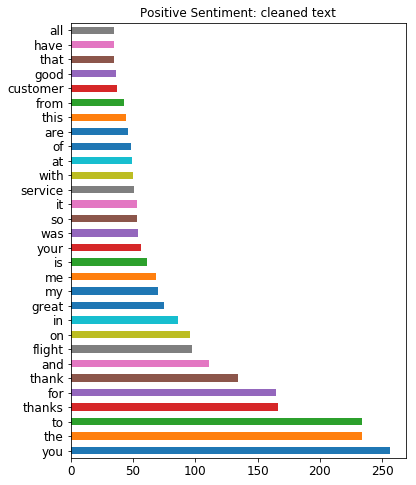

Index([u'you', u'the', u'to', u'thanks', u'for', u'thank', u'and', u'flight',
       u'on', u'in', u'great', u'my', u'me', u'is', u'your', u'was', u'so',
       u'it', u'service', u'with', u'at', u'of', u'are', u'this', u'from',
       u'customer', u'good', u'that', u'have', u'all'],
      dtype='object')


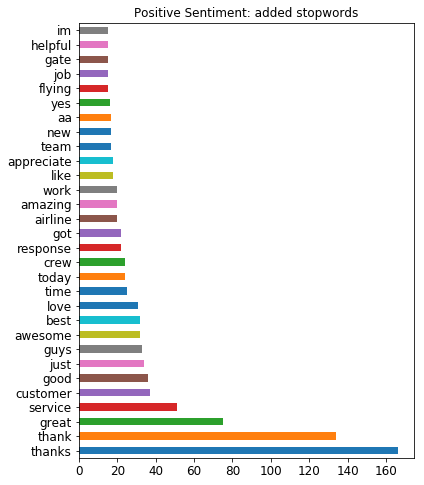

Index([u'thanks', u'thank', u'great', u'service', u'customer', u'good',
       u'just', u'guys', u'awesome', u'best', u'love', u'time', u'today',
       u'crew', u'response', u'got', u'airline', u'amazing', u'work', u'like',
       u'appreciate', u'team', u'new', u'aa', u'yes', u'flying', u'job',
       u'gate', u'helpful', u'im'],
      dtype='object')


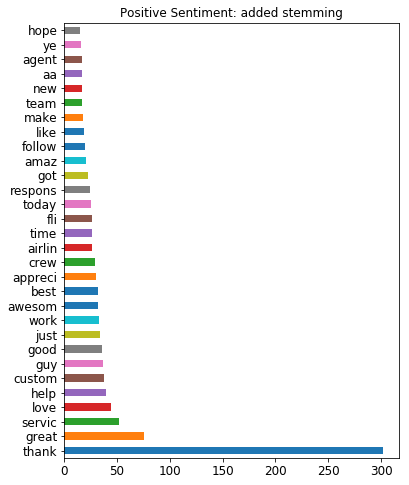

Index([u'thank', u'great', u'servic', u'love', u'help', u'custom', u'guy',
       u'good', u'just', u'work', u'awesom', u'best', u'appreci', u'crew',
       u'airlin', u'time', u'fli', u'today', u'respons', u'got', u'amaz',
       u'follow', u'like', u'make', u'team', u'new', u'aa', u'agent', u'ye',
       u'hope'],
      dtype='object')


In [95]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

In [96]:
def disp_negative_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "negative"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "negative"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Negative Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neg_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

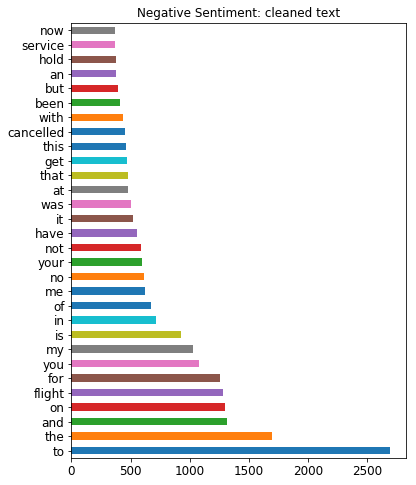

Index([u'to', u'the', u'and', u'on', u'flight', u'for', u'you', u'my', u'is',
       u'in', u'of', u'me', u'no', u'your', u'not', u'have', u'it', u'was',
       u'at', u'that', u'get', u'this', u'cancelled', u'with', u'been', u'but',
       u'an', u'hold', u'service', u'now'],
      dtype='object')


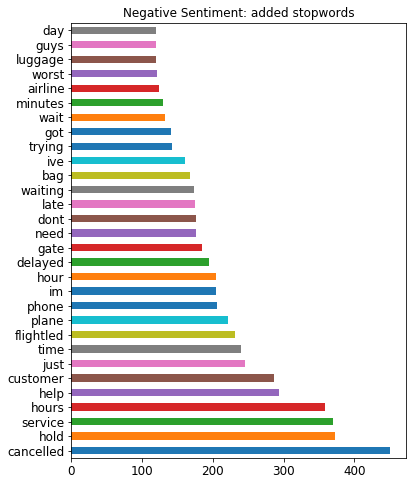

Index([u'cancelled', u'hold', u'service', u'hours', u'help', u'customer',
       u'just', u'time', u'flightled', u'plane', u'phone', u'im', u'hour',
       u'delayed', u'gate', u'need', u'dont', u'late', u'waiting', u'bag',
       u'ive', u'trying', u'got', u'wait', u'minutes', u'airline', u'worst',
       u'luggage', u'guys', u'day'],
      dtype='object')


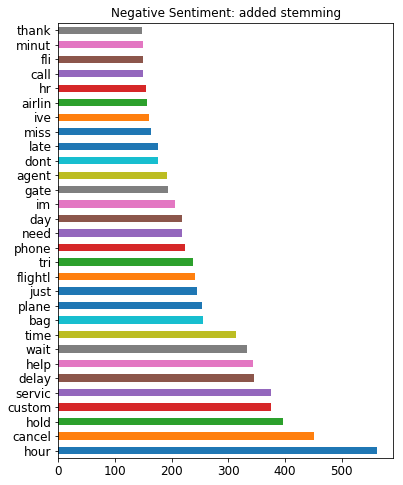

Index([u'hour', u'cancel', u'hold', u'custom', u'servic', u'delay', u'help',
       u'wait', u'time', u'bag', u'plane', u'just', u'flightl', u'tri',
       u'phone', u'need', u'day', u'im', u'gate', u'agent', u'dont', u'late',
       u'miss', u'ive', u'airlin', u'hr', u'call', u'fli', u'minut', u'thank'],
      dtype='object')


In [97]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

In [98]:
def disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams):

    # only cleaned text from formatting.
    words_sorted_ordimp = words_df[words_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: cleaned text', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_cleantext.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # added stopwords processing.
    words_sorted_ordimp = words_stop_df[words_stop_df.index == "neutral"].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: added stopwords', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_stopwused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

    # with stemming.
    words_sorted_ordimp = words_stem_df[words_stem_df.index == "neutral"].\
                                                        sum().sort_values(ascending=False)
    words_sorted_ordimp.head(30).plot(kind='barh', title='Neutral Sentiment: added stemming', 
                                      figsize=(6,8), fontsize=12)
    plt.savefig(img_out_dir+grams+'_neut_sent_stemused.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:30].index)

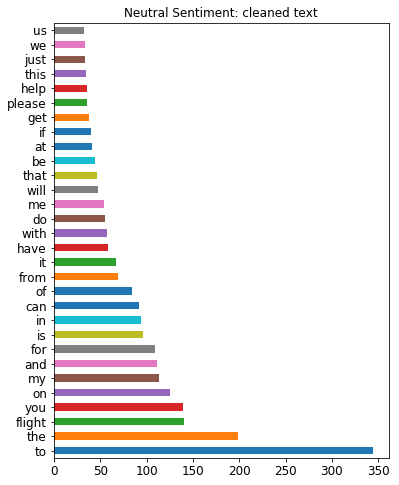

Index([u'to', u'the', u'flight', u'you', u'on', u'my', u'and', u'for', u'is',
       u'in', u'can', u'of', u'from', u'it', u'have', u'with', u'do', u'me',
       u'will', u'that', u'be', u'at', u'if', u'get', u'please', u'help',
       u'this', u'just', u'we', u'us'],
      dtype='object')


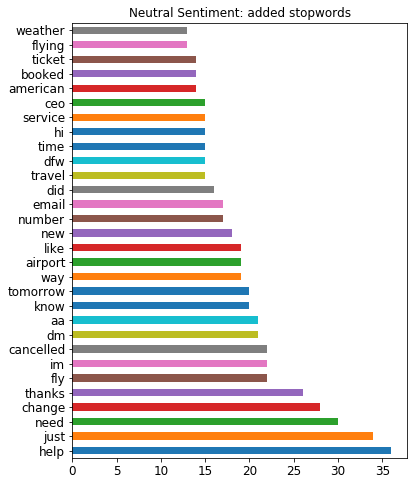

Index([u'help', u'just', u'need', u'change', u'thanks', u'fly', u'im',
       u'cancelled', u'dm', u'aa', u'know', u'tomorrow', u'way', u'airport',
       u'like', u'new', u'number', u'email', u'did', u'travel', u'dfw',
       u'time', u'hi', u'service', u'ceo', u'american', u'booked', u'ticket',
       u'flying', u'weather'],
      dtype='object')


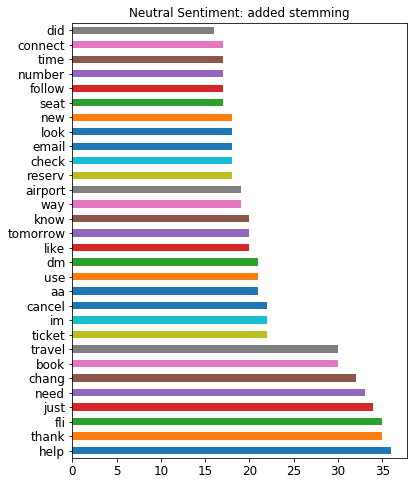

Index([u'help', u'thank', u'fli', u'just', u'need', u'chang', u'book',
       u'travel', u'ticket', u'im', u'cancel', u'aa', u'use', u'dm', u'like',
       u'tomorrow', u'know', u'way', u'airport', u'reserv', u'check', u'email',
       u'look', u'new', u'seat', u'follow', u'number', u'time', u'connect',
       u'did'],
      dtype='object')


In [99]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at bi-grams

In [100]:
grams = "Bigrams"

In [101]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(2,2))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(2,2))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(2,2))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [102]:
print(words_df.shape)
words_df.head(4)

(5112, 42034)


006 on  0223 got  02282015 until  03 back  0303 can  \
airline_sentiment                                                        
neutral                 0         0               0        0         0   
neutral                 0         0               0        0         0   
positive                0         0               0        0         0   
positive                0         0               0        0         0   

                   03032015 and  0316 am  0372389047497 totally  0600 wont  \
airline_sentiment                                                            
neutral                       0        0                      0          0   
neutral                       0        0                      0          0   
positive                      0        0                      0          0   
positive                      0        0                      0          0   

                   0671 strand       ...        zero information  \
airline_sentiment                    ...                           
neutral                      0       ...                       0   
neutral                      0       ...                       0   
positive                     0       ...                       0   
positive                     0       ...                       0   

                   zero respect  zero response  zero success  zfv yyz  \
airline_sentiment                                                       
neutral                       0              0             0        0   
neutral                       0              0             0        0   
positive                      0              0             0        0   
positive                      0              0             0        0   

                   zone boarded  zone change  zone was  zoom in  \
airline_sentiment                                                 
neutral                       0            0         0        0   
neutral                       0            0         0        0   
positive                      0            0         0        0   
positive                      0            0         0        0   

                   zurichnew york  
airline_sentiment                  
neutral                         0  
neutral                         0  
positive                        0  
positive                        0  

[4 rows x 42034 columns]

In [103]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5112, 29706)


006 news  0223 got  02282015 03032015  03 forth  0303 help  \
airline_sentiment                                                               
neutral                   0         0                  0         0          0   

                   03032015 dont  0372389047497 totally  0600 wont  \
airline_sentiment                                                    
neutral                        0                      0          0   

                   0671 strand  10 advice       ...        zero information  \
airline_sentiment                               ...                           
neutral                      0          0       ...                       0   

                   zero respect  zero response  zero success  zfv yyz  \
airline_sentiment                                                       
neutral                       0              0             0        0   

                   zone boarded  zone change  zone precious  zoom sauce  \
airline_sentiment                                                         
neutral                       0            0              0           0   

                   zurichnew york  
airline_sentiment                  
neutral                         0  

[1 rows x 29706 columns]

In [104]:
print(words_stem_df.shape)
words_stem_df.head(4)

(5112, 28290)


006 news  0223 got  02282015 03032015  03 forth  0303 help  \
airline_sentiment                                                               
neutral                   0         0                  0         0          0   
neutral                   0         0                  0         0          0   
positive                  0         0                  0         0          0   
positive                  0         0                  0         0          0   

                   03032015 dont  0372389047497 total  0600 wont  0671 strand  \
airline_sentiment                                                               
neutral                        0                    0          0            0   
neutral                        0                    0          0            0   
positive                       0                    0          0            0   
positive                       0                    0          0            0   

                   10 advic       ...        zero inform  zero respect  \
airline_sentiment                 ...                                    
neutral                   0       ...                  0             0   
neutral                   0       ...                  0             0   
positive                  0       ...                  0             0   
positive                  0       ...                  0             0   

                   zero respons  zero success  zfv yyz  zone board  \
airline_sentiment                                                    
neutral                       0             0        0           0   
neutral                       0             0        0           0   
positive                      0             0        0           0   
positive                      0             0        0           0   

                   zone chang  zone preciou  zoom sauc  zurichnew york  
airline_sentiment                                                       
neutral                     0             0          0               0  
neutral                     0             0          0               0  
positive                    0             0          0               0  
positive                    0             0          0               0  

[4 rows x 28290 columns]

In [105]:
# Feature dimension reduced from 47728 with cleaned text, to 35649 with stopwords and
# 34824 with stemming.

## Positive

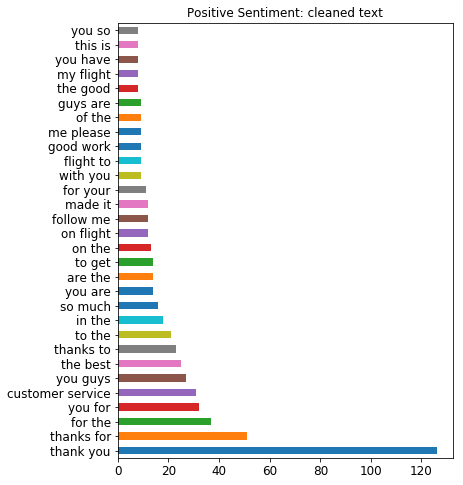

Index([u'thank you', u'thanks for', u'for the', u'you for',
       u'customer service', u'you guys', u'the best', u'thanks to', u'to the',
       u'in the', u'so much', u'you are', u'are the', u'to get', u'on the',
       u'on flight', u'follow me', u'made it', u'for your', u'with you',
       u'flight to', u'good work', u'me please', u'of the', u'guys are',
       u'the good', u'my flight', u'you have', u'this is', u'you so'],
      dtype='object')


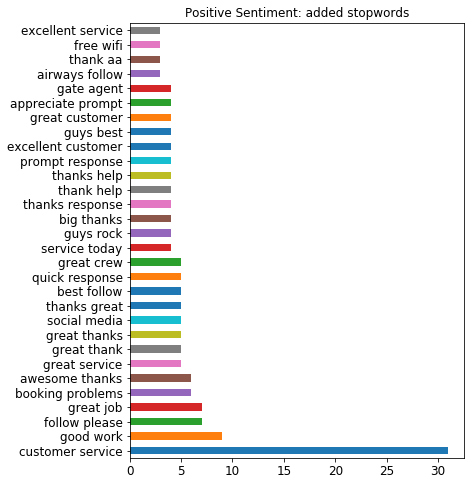

Index([u'customer service', u'good work', u'follow please', u'great job',
       u'booking problems', u'awesome thanks', u'great service',
       u'great thank', u'great thanks', u'social media', u'thanks great',
       u'best follow', u'quick response', u'great crew', u'service today',
       u'guys rock', u'big thanks', u'thanks response', u'thank help',
       u'thanks help', u'prompt response', u'excellent customer', u'guys best',
       u'great customer', u'appreciate prompt', u'gate agent',
       u'airways follow', u'thank aa', u'free wifi', u'excellent service'],
      dtype='object')


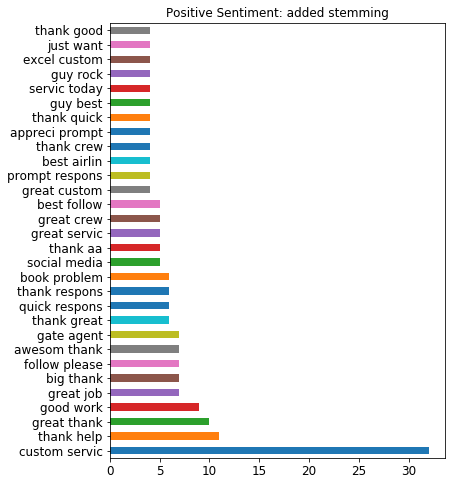

Index([u'custom servic', u'thank help', u'great thank', u'good work',
       u'great job', u'big thank', u'follow please', u'awesom thank',
       u'gate agent', u'thank great', u'quick respons', u'thank respons',
       u'book problem', u'social media', u'thank aa', u'great servic',
       u'great crew', u'best follow', u'great custom', u'prompt respons',
       u'best airlin', u'thank crew', u'appreci prompt', u'thank quick',
       u'guy best', u'servic today', u'guy rock', u'excel custom',
       u'just want', u'thank good'],
      dtype='object')


In [106]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

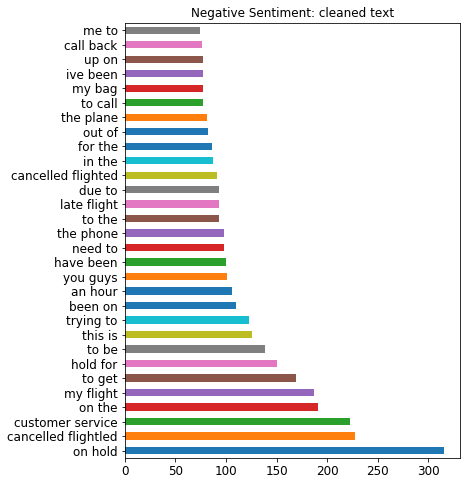

Index([u'on hold', u'cancelled flightled', u'customer service', u'on the',
       u'my flight', u'to get', u'hold for', u'to be', u'this is',
       u'trying to', u'been on', u'an hour', u'you guys', u'have been',
       u'need to', u'the phone', u'to the', u'late flight', u'due to',
       u'cancelled flighted', u'in the', u'for the', u'out of', u'the plane',
       u'to call', u'my bag', u'ive been', u'up on', u'call back', u'me to'],
      dtype='object')


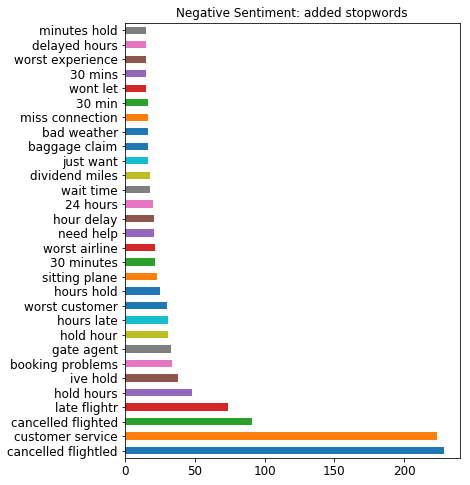

Index([u'cancelled flightled', u'customer service', u'cancelled flighted',
       u'late flightr', u'hold hours', u'ive hold', u'booking problems',
       u'gate agent', u'hold hour', u'hours late', u'worst customer',
       u'hours hold', u'sitting plane', u'30 minutes', u'worst airline',
       u'need help', u'hour delay', u'24 hours', u'wait time',
       u'dividend miles', u'just want', u'baggage claim', u'bad weather',
       u'miss connection', u'30 min', u'wont let', u'30 mins',
       u'worst experience', u'delayed hours', u'minutes hold'],
      dtype='object')


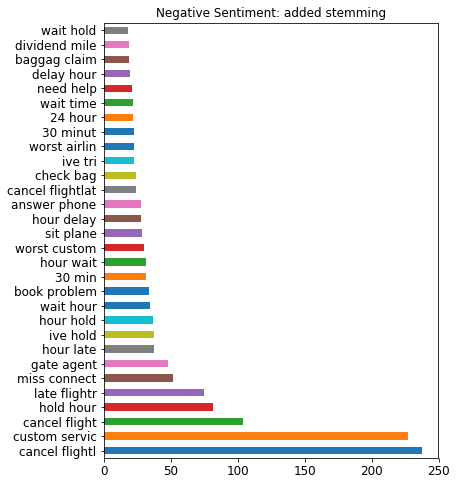

Index([u'cancel flightl', u'custom servic', u'cancel flight', u'hold hour',
       u'late flightr', u'miss connect', u'gate agent', u'hour late',
       u'ive hold', u'hour hold', u'wait hour', u'book problem', u'30 min',
       u'hour wait', u'worst custom', u'sit plane', u'hour delay',
       u'answer phone', u'cancel flightlat', u'check bag', u'ive tri',
       u'worst airlin', u'30 minut', u'24 hour', u'wait time', u'need help',
       u'delay hour', u'baggag claim', u'dividend mile', u'wait hold'],
      dtype='object')


In [107]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

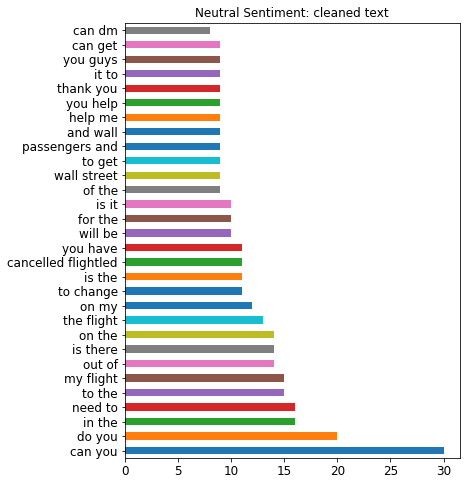

Index([u'can you', u'do you', u'in the', u'need to', u'to the', u'my flight',
       u'out of', u'is there', u'on the', u'the flight', u'on my',
       u'to change', u'is the', u'cancelled flightled', u'you have',
       u'will be', u'for the', u'is it', u'of the', u'wall street', u'to get',
       u'passengers and', u'and wall', u'help me', u'you help', u'thank you',
       u'it to', u'you guys', u'can get', u'can dm'],
      dtype='object')


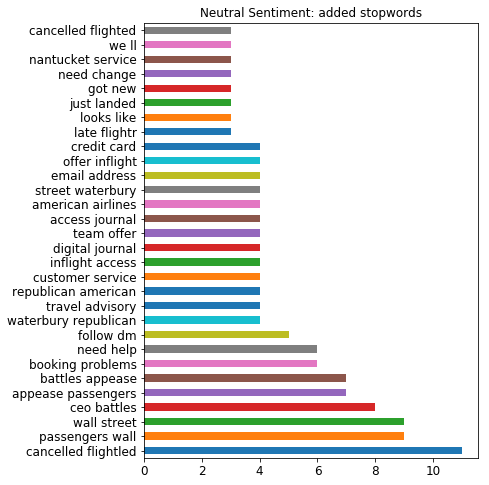

Index([u'cancelled flightled', u'passengers wall', u'wall street',
       u'ceo battles', u'appease passengers', u'battles appease',
       u'booking problems', u'need help', u'follow dm',
       u'waterbury republican', u'travel advisory', u'republican american',
       u'customer service', u'inflight access', u'digital journal',
       u'team offer', u'access journal', u'american airlines',
       u'street waterbury', u'email address', u'offer inflight',
       u'credit card', u'late flightr', u'looks like', u'just landed',
       u'got new', u'need change', u'nantucket service', u'we ll',
       u'cancelled flighted'],
      dtype='object')


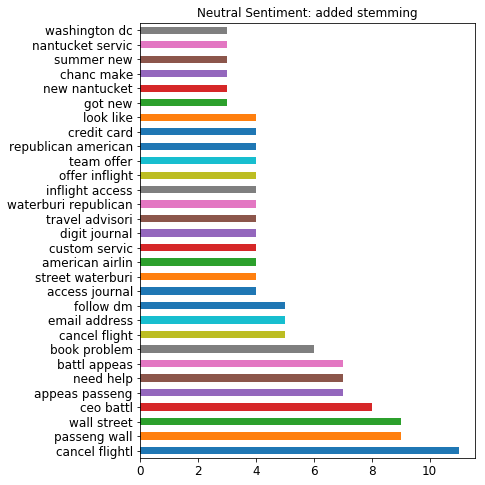

Index([u'cancel flightl', u'passeng wall', u'wall street', u'ceo battl',
       u'appeas passeng', u'need help', u'battl appeas', u'book problem',
       u'cancel flight', u'email address', u'follow dm', u'access journal',
       u'street waterburi', u'american airlin', u'custom servic',
       u'digit journal', u'travel advisori', u'waterburi republican',
       u'inflight access', u'offer inflight', u'team offer',
       u'republican american', u'credit card', u'look like', u'got new',
       u'new nantucket', u'chanc make', u'summer new', u'nantucket servic',
       u'washington dc'],
      dtype='object')


In [108]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

# Look at tri-grams

In [109]:
grams = "Trigrams"

In [110]:
# vectorize text with 'only cleaning' applied to it.
cv = CountVectorizer(ngram_range=(3,3))
X_cv = cv.fit_transform(air_sub_df['clean_text'])

words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
words_df.index = y

# vectorize text with 'stopwords' applied to it.
cv_stop = CountVectorizer(ngram_range=(3,3))
X_cv_stop = cv_stop.fit_transform(air_sub_df['stopw_clean_text'])

words_stop_df = pd.DataFrame(X_cv_stop.toarray(), columns=cv_stop.get_feature_names())
words_stop_df.index = y

# vectorize text 'with stemming' applied to it.
cv_stem = CountVectorizer(ngram_range=(3,3))
X_cv_stem = cv_stem.fit_transform(air_sub_df['stem_stopw_clean_text'])

words_stem_df = pd.DataFrame(X_cv_stem.toarray(), columns=cv_stem.get_feature_names())
words_stem_df.index = y

In [111]:
# with stemming feature dimensionality reduced from 31667 to 31471.

In [112]:
print(words_df.shape)
words_df.head(1)

(5112, 62796)


006 on news  0223 got cncled  02282015 until the  \
airline_sentiment                                                     
neutral                      0                0                   0   

                   03 back and  0303 can you  03032015 and they  \
airline_sentiment                                                 
neutral                      0             0                  0   

                   0372389047497 totally unacceptable  0600 wont let  \
airline_sentiment                                                      
neutral                                             0              0   

                   0671 strand me  10 am office          ...            \
airline_sentiment                                        ...             
neutral                         0             0          ...             

                   zero information please  zero respect for  \
airline_sentiment                                              
neutral                                  0                 0   

                   zero response from  zero response never  zfv yyz usairways  \
airline_sentiment                                                               
neutral                             0                    0                  0   

                   zone boarded overhead  zone change to  zone was after  \
airline_sentiment                                                          
neutral                                0               0               0   

                   zoom in on  zurichnew york thanks  
airline_sentiment                                     
neutral                     0                      0  

[1 rows x 62796 columns]

In [113]:
print(words_stop_df.shape)
words_stop_df.head(1)

(5112, 30230)


006 news airways  0223 got cncled  02282015 03032015 dont  \
airline_sentiment                                                              
neutral                           0                0                       0   

                   03 forth gatwick  03032015 dont want  \
airline_sentiment                                         
neutral                           0                   0   

                   0372389047497 totally unacceptable  0600 wont let  \
airline_sentiment                                                      
neutral                                             0              0   

                   0671 strand phx  10 al shes  10 bucks middle  \
airline_sentiment                                                 
neutral                          0           0                0   

                           ...            zero information send  \
airline_sentiment          ...                                    
neutral                    ...                                0   

                   zero respect passengers  zero response traveling  \
airline_sentiment                                                     
neutral                                  0                        0   

                   zero response tweet  zfv yyz baggagelost  \
airline_sentiment                                             
neutral                              0                    0   

                   zone boarded overhead  zone change est  zone precious gems  \
airline_sentiment                                                               
neutral                                0                0                   0   

                   zoom sauce potatoes  zurichnew york thanks  
airline_sentiment                                              
neutral                              0                      0  

[1 rows x 30230 columns]

In [114]:
print(words_stem_df.shape)
words_stem_df.head(1)

(5112, 30022)


006 news airway  0223 got cncled  02282015 03032015 dont  \
airline_sentiment                                                             
neutral                          0                0                       0   

                   03 forth gatwick  03032015 dont want  \
airline_sentiment                                         
neutral                           0                   0   

                   0372389047497 total unaccept  0600 wont let  \
airline_sentiment                                                
neutral                                       0              0   

                   0671 strand phx  10 al she  10 buck middl  \
airline_sentiment                                              
neutral                          0          0              0   

                           ...           zero inform send  \
airline_sentiment          ...                              
neutral                    ...                          0   

                   zero respect passeng  zero respons travel  \
airline_sentiment                                              
neutral                               0                    0   

                   zero respons tweet  zfv yyz baggagelost  \
airline_sentiment                                            
neutral                             0                    0   

                   zone board overhead  zone chang est  zone preciou gem  \
airline_sentiment                                                          
neutral                              0               0                 0   

                   zoom sauc potato  zurichnew york thank  
airline_sentiment                                          
neutral                           0                     0  

[1 rows x 30022 columns]

In [115]:
# dimensionality reduced from 72896, to 36572, 36269

## Positive

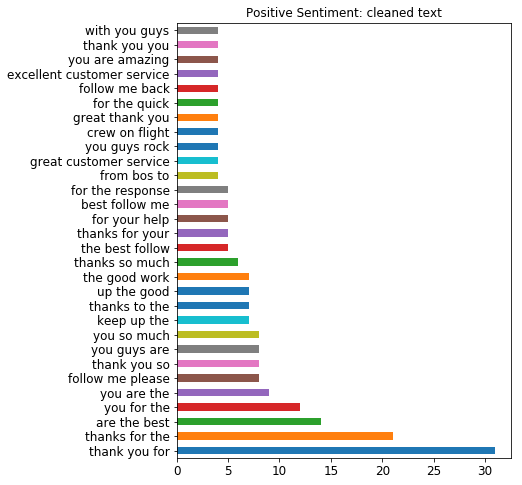

Index([u'thank you for', u'thanks for the', u'are the best', u'you for the',
       u'you are the', u'follow me please', u'thank you so', u'you guys are',
       u'you so much', u'keep up the', u'thanks to the', u'up the good',
       u'the good work', u'thanks so much', u'the best follow',
       u'thanks for your', u'for your help', u'best follow me',
       u'for the response', u'from bos to', u'great customer service',
       u'you guys rock', u'crew on flight', u'great thank you',
       u'for the quick', u'follow me back', u'excellent customer service',
       u'you are amazing', u'thank you you', u'with you guys'],
      dtype='object')


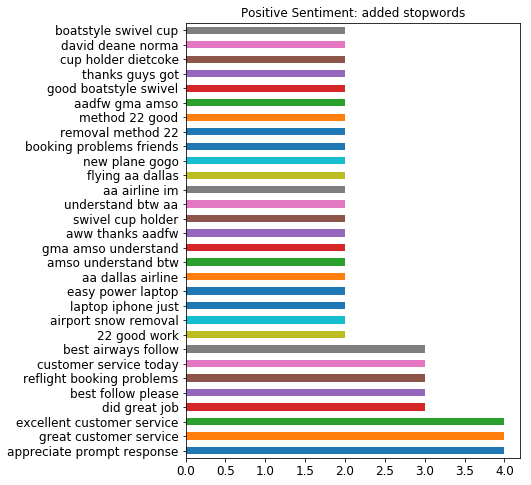

Index([u'appreciate prompt response', u'great customer service',
       u'excellent customer service', u'did great job', u'best follow please',
       u'reflight booking problems', u'customer service today',
       u'best airways follow', u'22 good work', u'airport snow removal',
       u'laptop iphone just', u'easy power laptop', u'aa dallas airline',
       u'amso understand btw', u'gma amso understand', u'aww thanks aadfw',
       u'swivel cup holder', u'understand btw aa', u'aa airline im',
       u'flying aa dallas', u'new plane gogo', u'booking problems friends',
       u'removal method 22', u'method 22 good', u'aadfw gma amso',
       u'good boatstyle swivel', u'thanks guys got', u'cup holder dietcoke',
       u'david deane norma', u'boatstyle swivel cup'],
      dtype='object')


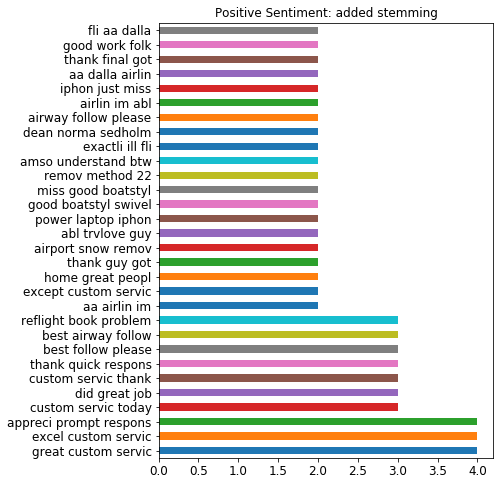

Index([u'great custom servic', u'excel custom servic',
       u'appreci prompt respons', u'custom servic today', u'did great job',
       u'custom servic thank', u'thank quick respons', u'best follow please',
       u'best airway follow', u'reflight book problem', u'aa airlin im',
       u'except custom servic', u'home great peopl', u'thank guy got',
       u'airport snow remov', u'abl trvlove guy', u'power laptop iphon',
       u'good boatstyl swivel', u'miss good boatstyl', u'remov method 22',
       u'amso understand btw', u'exactli ill fli', u'dean norma sedholm',
       u'airway follow please', u'airlin im abl', u'iphon just miss',
       u'aa dalla airlin', u'thank final got', u'good work folk',
       u'fli aa dalla'],
      dtype='object')


In [116]:
disp_positive_grams(words_df, words_stop_df, words_stem_df, grams)

## Negative

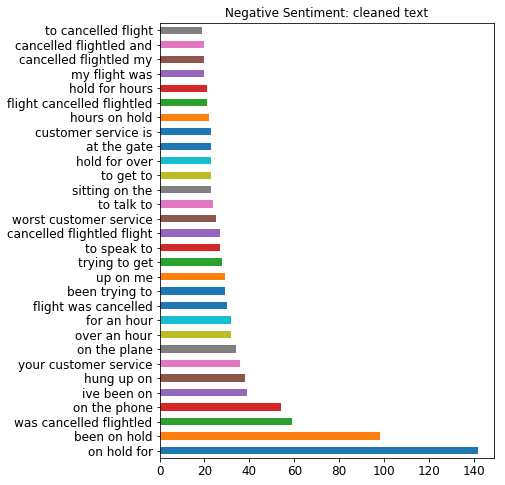

Index([u'on hold for', u'been on hold', u'was cancelled flightled',
       u'on the phone', u'ive been on', u'hung up on',
       u'your customer service', u'on the plane', u'over an hour',
       u'for an hour', u'flight was cancelled', u'been trying to', u'up on me',
       u'trying to get', u'to speak to', u'cancelled flightled flight',
       u'worst customer service', u'to talk to', u'sitting on the',
       u'to get to', u'hold for over', u'at the gate', u'customer service is',
       u'hours on hold', u'flight cancelled flightled', u'hold for hours',
       u'my flight was', u'cancelled flightled my', u'cancelled flightled and',
       u'to cancelled flight'],
      dtype='object')


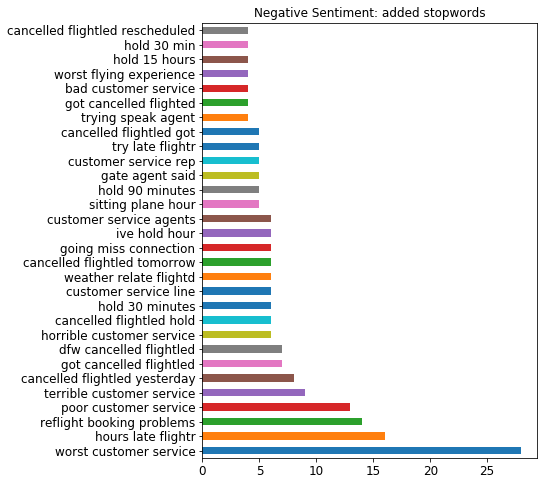

Index([u'worst customer service', u'hours late flightr',
       u'reflight booking problems', u'poor customer service',
       u'terrible customer service', u'cancelled flightled yesterday',
       u'got cancelled flightled', u'dfw cancelled flightled',
       u'horrible customer service', u'cancelled flightled hold',
       u'hold 30 minutes', u'customer service line', u'weather relate flightd',
       u'cancelled flightled tomorrow', u'going miss connection',
       u'ive hold hour', u'customer service agents', u'sitting plane hour',
       u'hold 90 minutes', u'gate agent said', u'customer service rep',
       u'try late flightr', u'cancelled flightled got', u'trying speak agent',
       u'got cancelled flighted', u'bad customer service',
       u'worst flying experience', u'hold 15 hours', u'hold 30 min',
       u'cancelled flightled rescheduled'],
      dtype='object')


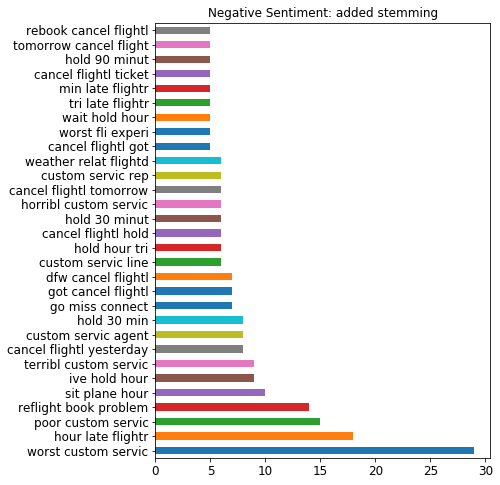

Index([u'worst custom servic', u'hour late flightr', u'poor custom servic',
       u'reflight book problem', u'sit plane hour', u'ive hold hour',
       u'terribl custom servic', u'cancel flightl yesterday',
       u'custom servic agent', u'hold 30 min', u'go miss connect',
       u'got cancel flightl', u'dfw cancel flightl', u'custom servic line',
       u'hold hour tri', u'cancel flightl hold', u'hold 30 minut',
       u'horribl custom servic', u'cancel flightl tomorrow',
       u'custom servic rep', u'weather relat flightd', u'cancel flightl got',
       u'worst fli experi', u'wait hold hour', u'tri late flightr',
       u'min late flightr', u'cancel flightl ticket', u'hold 90 minut',
       u'tomorrow cancel flight', u'rebook cancel flightl'],
      dtype='object')


In [117]:
disp_negative_grams(words_df, words_stop_df, words_stem_df, grams)

## Neutral

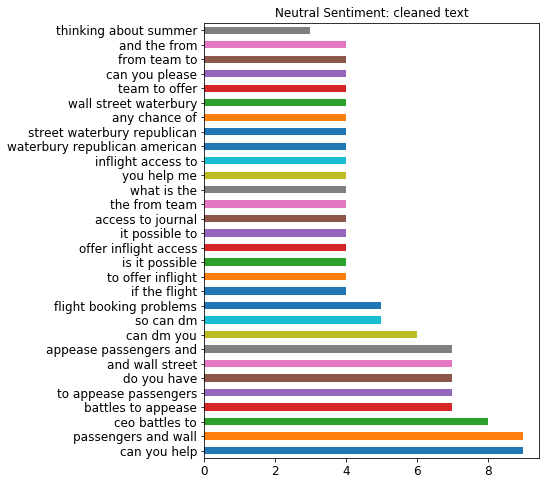

Index([u'can you help', u'passengers and wall', u'ceo battles to',
       u'battles to appease', u'to appease passengers', u'do you have',
       u'and wall street', u'appease passengers and', u'can dm you',
       u'so can dm', u'flight booking problems', u'if the flight',
       u'to offer inflight', u'is it possible', u'offer inflight access',
       u'it possible to', u'access to journal', u'the from team',
       u'what is the', u'you help me', u'inflight access to',
       u'waterbury republican american', u'street waterbury republican',
       u'any chance of', u'wall street waterbury', u'team to offer',
       u'can you please', u'from team to', u'and the from',
       u'thinking about summer'],
      dtype='object')


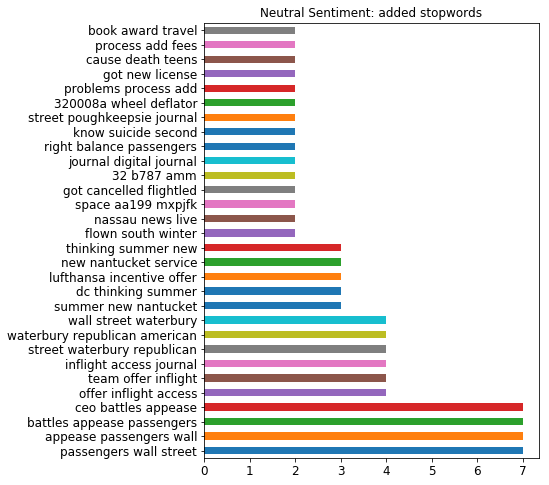

Index([u'passengers wall street', u'appease passengers wall',
       u'battles appease passengers', u'ceo battles appease',
       u'offer inflight access', u'team offer inflight',
       u'inflight access journal', u'street waterbury republican',
       u'waterbury republican american', u'wall street waterbury',
       u'summer new nantucket', u'dc thinking summer',
       u'lufthansa incentive offer', u'new nantucket service',
       u'thinking summer new', u'flown south winter', u'nassau news live',
       u'space aa199 mxpjfk', u'got cancelled flightled', u'32 b787 amm',
       u'journal digital journal', u'right balance passengers',
       u'know suicide second', u'street poughkeepsie journal',
       u'320008a wheel deflator', u'problems process add', u'got new license',
       u'cause death teens', u'process add fees', u'book award travel'],
      dtype='object')


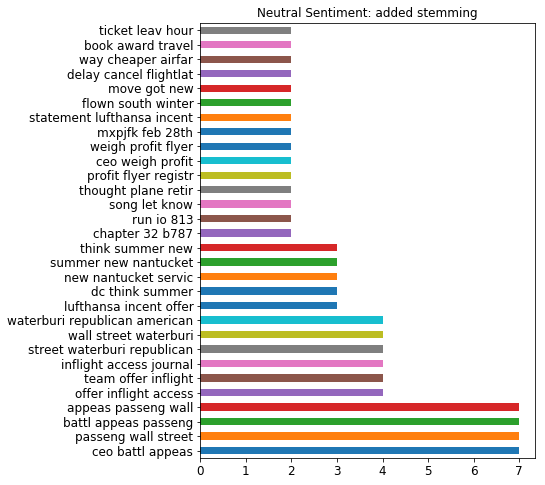

Index([u'ceo battl appeas', u'passeng wall street', u'battl appeas passeng',
       u'appeas passeng wall', u'offer inflight access',
       u'team offer inflight', u'inflight access journal',
       u'street waterburi republican', u'wall street waterburi',
       u'waterburi republican american', u'lufthansa incent offer',
       u'dc think summer', u'new nantucket servic', u'summer new nantucket',
       u'think summer new', u'chapter 32 b787', u'run io 813',
       u'song let know', u'thought plane retir', u'profit flyer registr',
       u'ceo weigh profit', u'weigh profit flyer', u'mxpjfk feb 28th',
       u'statement lufthansa incent', u'flown south winter', u'move got new',
       u'delay cancel flightlat', u'way cheaper airfar', u'book award travel',
       u'ticket leav hour'],
      dtype='object')


In [118]:
disp_neutral_grams(words_df, words_stop_df, words_stem_df, grams)

In [119]:
# Pickle dataframe with added columns with processed and cleaned text.
import pickle

In [122]:
filename = data_out_dir+'airline_cl_process_dataset_df2'
filehandler = open(filename,"wb")
pickle.dump(air_sub_df,filehandler)

In [123]:
file = open(filename,'rb')
object_content = pickle.load(file)

In [ ]:
#**************** I did not encode emojis. What did count vectorizer do with them? Let's explore.

In [124]:
# emoji in text.
text1 = air_sub_df.loc[8002, 'clean_text']
text2 = air_sub_df.loc[8001, 'stopw_clean_text']

In [125]:
text1, text2

(u'he loved the natural beefjerky snacks\U0001f609',
 u'im flying airline just lga \U0001f637')

In [126]:
def disp_transformed_text_tokens(vectorizer, text):
    text_vect = vectorizer.transform([text])
    text_df = pd.DataFrame(text_vect.toarray(), columns=vectorizer.get_feature_names())
    words = text_df.sum().sort_values(ascending=False)
    words.head(10).plot(kind='barh',figsize=(3,4), fontsize=12)
    print(text)
    plt.show()

he loved the natural beefjerky snacks😉


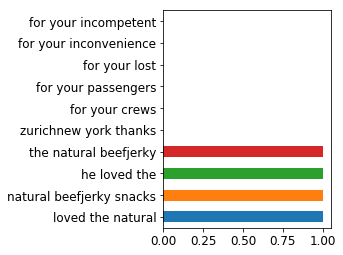

im flying airline just lga 😷


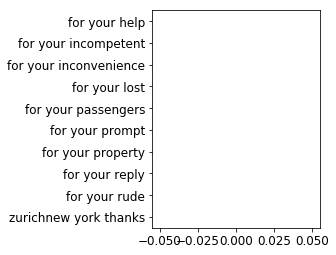

In [128]:
disp_transformed_text_tokens(cv, text1)
disp_transformed_text_tokens(cv, text2)

In [ ]:
# Emojis not encoded. Explore this further in another notebook.